In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1 Functions

In [137]:
##========================================================================
## Process consectutive missing data
##========================================================================
def preprocess_data(df, MID, effective_start_time, effective_end_time, pvsize, fillmethod):
    # df = [time, power generation]
    # replace the negative values with zero
    df.loc[df[MID]<0, MID] = 0
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    # Step 1. replace outlier (larger than pvsize) with nan
    df_outlier_idx = df[df[MID].astype(float) > 1.2*pvsize]
    df.iloc[df_outlier_idx.index.to_list(), 1] = np.nan
    df.set_index('time', inplace=True)
    # Step 2. fill missing data
    if fillmethod == 'linear':
        df[MID] = df[MID].interpolate()
    elif fillmethod == 'time':
        df[MID] = df[MID].interpolate(method='time')
    elif fillmethod == 'nearest':
        df[MID] = df[MID].interpolate(method='nearest')
    elif (fillmethod == 'ffill') | (fillmethod == 'bfill'): # Replace NaN with preceding values
        df[MID].fillna(method='ffill', inplace=True)
        df[MID].fillna(method='bfill', inplace=True)
    else:
        RecursionError('Please check the fill method')
    df[MID].fillna(0, inplace=True)
    # Step 3. night time should be zero
    df.loc[(df['hour']<effective_start_time)|(df['hour']>effective_end_time), MID] = 0
    df.reset_index(inplace=True)
    return df

In [138]:
# Create a function to apply to each element in the DataFrame
def set_to_true_or_nan(x):
    if pd.isna(x):
        return x
    return x > 0.8

In [139]:
##========================================================================
## clear-sky days
##========================================================================
def clearsky_cal(date_start, date_end):
    # read the clear-sky model generation for different PV sites
    df_site = pd.read_csv('../preprocessed_data/PVsite_daily_20231016.csv')

    df_site_clearsky = df_site.filter(like='EnergyYield.kWh.Daily')
    split_columns = df_site_clearsky.columns.str.split(':').str[1]
    df_site_clearsky.columns = split_columns
    df_site_clearsky.insert(0, 'date', df_site['date'].values)
    df_site_clearsky = df_site_clearsky[(df_site_clearsky['date'] >= date_start) & (df_site_clearsky['date'] <= date_end)]

    # read the expected generation of different PV sites
    df_site_expected = df_site.filter(like='Irrad.kWh.m2.Daily')
    split_columns = df_site_expected.columns.str.split(':').str[1]
    df_site_expected.columns = split_columns
    df_site_expected.insert(0, 'date', df_site['date'].values)
    df_site_expected = df_site_expected[(df_site_expected['date'] >= date_start) & (df_site_expected['date'] <= date_end)]

    # Calculate the cloudiness
    df_cloudiness = df_site_clearsky.copy()
    df_cloudiness.iloc[:, 1:] = df_site_expected.iloc[:, 1:]/df_site_clearsky.iloc[:, 1:]
    df_cloudiness.iloc[:, 1:] = df_cloudiness.iloc[:, 1:].astype(float)
    df_cloudiness.dropna(how='all', axis=1, inplace=True)
    df_cloudiness.iloc[:, 1:].fillna(axis=1, method='ffill', inplace=True)

    df_clearday_sites = df_cloudiness.copy()

    # Apply the function to the entire DataFrame
    df_clearday_sites.iloc[:, 1:] = df_clearday_sites.iloc[:, 1:].applymap(set_to_true_or_nan)
    return df_clearday_sites

# 2 Parameter Settings

In [140]:
fillmethod = 'nearest' # preprocess missing data
if_only_clearsky = True
start_date = '2023-04-01'
end_date = '2023-05-01'
timeslots_daily = 21*12
# 5am - 20 pm
effective_start_time = 5
effective_end_time = 20
effective_timeslots_daily = (effective_end_time-effective_start_time + 1)*4
# threshold values
threshold_low_cloudiness = 0.9
threshold_for_effective_power = 0.2 # normalised one with PV size
threshold_for_effective_time = 0.5 # at least half data is effective, then it will be considered for fault detection

# MID
MID = 'MNTR|7053139'

effective_timeslots_daily

64

# 3 Read and Preprocess Data

In [ ]:
# read meta table
df_att = pd.read_csv('../input_data/MNTR_ddb_20230630.csv', header=0)
att_list = ['latitude', 'longitude', 'tilt', 'azimuth', 'loss', 'pvSizeWatt']
df_att['latitude'] = [x[1:] for x in df_att['latitude']]

site_id = df_att.loc[df_att['source']==MID, 'siteId'].values[0]
# df_att.head()

## 3.1 Read raw data

In [ ]:
# =============== 3. read data of different pv systems & identify its time resolution ===============
df_5min = pd.read_csv('../preprocessed_data/5min_rawdata_20230630.csv', index_col=0)
df_15min = pd.read_csv('../preprocessed_data/15min_rawdata_20230630.csv', index_col=0)

df_5min['time'] = pd.to_datetime(df_5min['time'])
df_15min['time'] = pd.to_datetime(df_15min['time'])
# ===============  Downsample 5min data to 15min data ===============
df_5min.set_index('time', inplace=True)
df_5min_down =  df_5min.resample('15T').mean()
df_5min_down.reset_index(inplace=True)
# ===============  combine data of 15min and the downsampled 5min ===============
df = pd.merge_asof(df_15min, df_5min_down, on='time')
df = df[(df['time']>=start_date) & (df['time']<=end_date)]
df.index = np.arange(len(df))
# df.head()

## 3.2 Data Preprocessing

In [143]:
# ===================== Data preprocessing of pv systems  ==============
df_preprocessed = df.copy()
pvlist = [x for x in df.columns.to_list() if x.startswith('MNTR')]
print('PV number before preprocessing missing data:', len(pvlist))
for i, MIDP in enumerate(pvlist):
    df_attpv = df_att[df_att['source']==MIDP]
    pvsize = df_attpv['pvSizeWatt'].values[0]
    df_pv = preprocess_data(df=df_preprocessed[['time', MIDP]].copy(), MID=MIDP, effective_start_time=effective_start_time, effective_end_time=effective_end_time, pvsize=pvsize, fillmethod=fillmethod)
    df_pvvalues = df_pv[MIDP].values
    df_preprocessed[MIDP] = df_pvvalues

df_preprocessed.head()

PV number before preprocessing missing data: 980


time  MNTR|cf146ea2-85e5-493d-bc10-95451b81c306  \
0 2023-04-01 00:00:00+00:00                                        0.0   
1 2023-04-01 00:15:00+00:00                                        0.0   
2 2023-04-01 00:30:00+00:00                                        0.0   
3 2023-04-01 00:45:00+00:00                                        0.0   
4 2023-04-01 01:00:00+00:00                                        0.0   

   MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  MNTR|1367154  \
0                                        0.0           0.0   
1                                        0.0           0.0   
2                                        0.0           0.0   
3                                        0.0           0.0   
4                                        0.0           0.0   

   MNTR|7KWG-VNRN-6XNR-G3P8  MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5  \
0                       0.0                                        0.0   
1                       0.0                                        0.0   
2                       0.0                                        0.0   
3                       0.0                                        0.0   
4                       0.0                                        0.0   

   MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   MNTR|18fa6b52-3a60-4237-8a57-92df002e6a75  ...  MNTR|3172589  MNTR|7721843  \
0                                        0.0  ...           0.0           0.0   
1                                        0.0  ...           0.0           0.0   
2                                        0.0  ...           0.0           0.0   
3                                        0.0  ...           0.0           0.0   
4                                        0.0  ...           0.0           0.0   

   MNTR|1162569_1_1_1  MNTR|1206026_1_2_1  MNTR|0001c02a2a1b  MNTR|918952  \
0                 0.0                 0.0                0.0          0.0   
1                 0.0                 0.0                0.0          0.0   
2                 0.0                 0.0                0.0          0.0   
3                 0.0                 0.0                0.0          0.0   
4                 0.0                 0.0                0.0          0.0   

   MNTR|1148485_1_1_1  MNTR|5556047  MNTR|6039646  MNTR|1189660_1_2_1  
0                 0.0           0.0           0.0                 0.0  
1                 0.0           0.0           0.0                 0.0  
2                 0.0           0.0           0.0                 0.0  
3                 0.0           0.0           0.0                 0.0  
4                 0.0           0.0           0.0                 0.0  

[5 rows x 981 columns]

In [144]:
# ======================= remove the monitors with time zone issue ==============
df_check = df_preprocessed.copy()
# df_check.reset_index(inplace=True)
df_check['hour'] = df_check['time'].dt.hour
df_check = df_check[(df_check['hour']==5) | (df_check['hour']==22)]
df_check.set_index('time', inplace=True)

remove_col_list = [x for x in df_check.columns.to_list() if not x.startswith('MNTR')]
df_check.drop(remove_col_list, axis=1, inplace=True)
df_check = df_check[df_check>100]
df_check.dropna(how='all', axis='columns', inplace=True)
timezone_issue_list = df_check.columns.to_list()
print(timezone_issue_list)
print('total pv sites with wrong time zone:', len(timezone_issue_list))
if len(timezone_issue_list)!=0:
    df_preprocessed.drop(timezone_issue_list, axis=1, inplace=True)

['MNTR|cf146ea2-85e5-493d-bc10-95451b81c306', 'MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5', 'MNTR|18fa6b52-3a60-4237-8a57-92df002e6a75', 'MNTR|c77c8d2d-a961-4587-b26b-df05e37b82b2', 'MNTR|12ff7bac-0cb1-46fa-8a92-eb2105012e17', 'MNTR|1677d16a-f97d-446f-b8f4-abb86e387e4b', 'MNTR|71ad6f09-1b55-4a6b-a29d-be9fcb167d91', 'MNTR|410c7748-ba5b-4ca3-96a3-a8cacf697948', 'MNTR|b5e46692-a2ef-4c53-af23-58bc35575686', 'MNTR|01a5db3e-3910-4d81-b921-5ae3564b5f56', 'MNTR|cd9ea8a5-a7b0-4c03-a0bd-89791226607a', 'MNTR|2d23f7bb-c314-4017-8d9f-1b75e218b1f3', 'MNTR|8ef8b649-f1a3-40b0-b214-a0dc326b0c3c', 'MNTR|472e3b2d-4ef9-478b-bc05-05a581d861a4', 'MNTR|e5648ccc-77b4-4902-a8f2-a51ed45c8e07', 'MNTR|c4f1dfae-9489-492a-9efc-0085a1f51e20', 'MNTR|33a32527-5ccd-4811-8be2-e3a5cdbf63cd', 'MNTR|63fa00d5-d7c2-4ed2-8d18-6a6cb4a88354', 'MNTR|f8743293-9cf7-4189-9fe3-d27e31832331', 'MNTR|a5debb1e-c8da-40d7-9d6b-f7dc1f6056d7', 'MNTR|b4966e42-a8de-4613-9278-51071068521d', 'MNTR|e49ca0fd-78f9-464e-88a5-9e0678f57749', 'MNTR|fb7

<Axes: xlabel='time'>

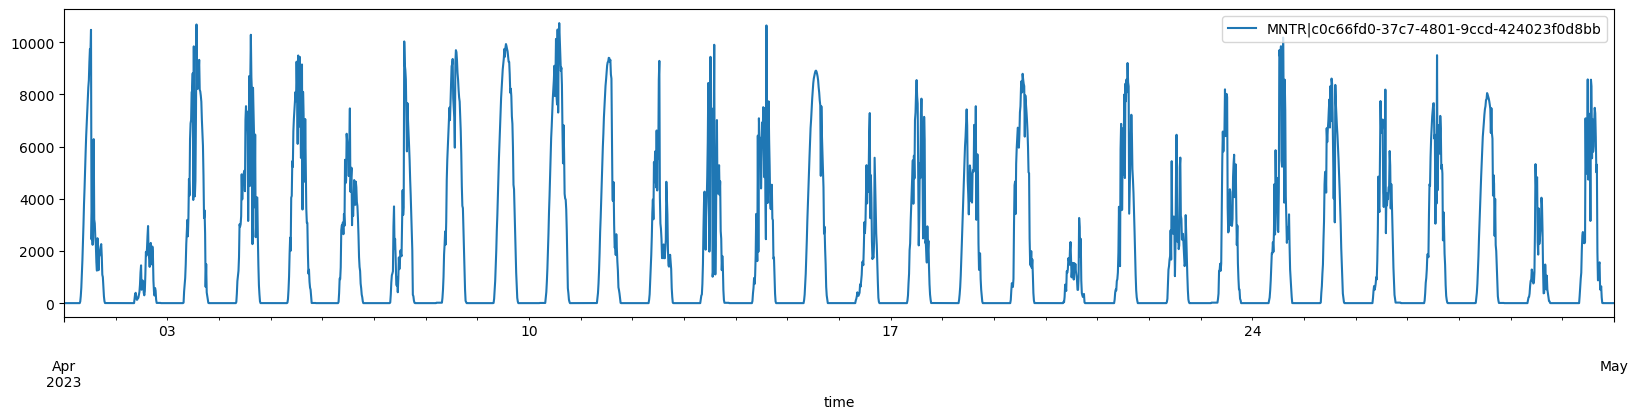

In [145]:
df_preprocessed.iloc[:, 0:2].set_index('time').plot(figsize=(20,4))

## 3.3 Plot Each monitor in each day

In [146]:
# save_fig_path = 'plots/clustering/short_term_ac'
# if not os.path.exists(save_fig_path):
#     os.makedirs(save_fig_path)

# def plt_daily_power(df):
#     pvlist = df.columns.to_list()[1:]
#     for pvid in pvlist:
#         fig, axes = plt.subplots(nrows=1, figsize=(16, 5))
#         axes.plot(df['time'].values, df[pvid].values, marker='o')
#         # ticks, labels = plt.xticks()
#         # plt.xticks(ticks[::5], labels[::5])
#         axes.grid(axis='y')
#         plt.savefig(save_fig_path + '/{}.png'.format(pvid))
#         plt.close()

# plt_daily_power(df=df_preprocessed)

## 3.4 Normalised Data

In [147]:
# normalise each monitor with the PV size
df_normalised = pd.DataFrame(index=np.arange(len(df_preprocessed)))
df_normalised['time'] = df_preprocessed['time'].values

pvlist = df_preprocessed.columns.to_list()[1:]
for pvid in pvlist:
    pvsize = df_att.loc[df_att['source']==pvid, 'pvSizeWatt'].values[0]
    df_normalised[pvid] = df_preprocessed[pvid]/pvsize

df_normalised['date'] = df_normalised['time'].dt.date
df_normalised['date'] = df_normalised['date'].astype(str)
df_normalised.iloc[40:45, :]

time  MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
40 2023-04-01 10:00:00                                   0.346699   
41 2023-04-01 10:15:00                                   0.384034   
42 2023-04-01 10:30:00                                   0.411465   
43 2023-04-01 10:45:00                                   0.442677   
44 2023-04-01 11:00:00                                   0.469748   

    MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  MNTR|1367154  \
40                                   0.070904      0.241070   
41                                   0.103205      0.192382   
42                                   0.171372      0.291992   
43                                   0.189557      0.313043   
44                                   0.198740      0.259049   

    MNTR|7KWG-VNRN-6XNR-G3P8  MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78  \
40                       0.0                                   0.303584   
41                       0.0                                   0.343033   
42                       0.0                                   0.318006   
43                       0.0                                   0.297434   
44                       0.0                                   0.317667   

    MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842  \
40                                   0.170040   
41                                   0.242456   
42                                   0.431617   
43                                   0.394418   
44                                   0.410335   

    MNTR|f1c33770-3ab6-4beb-9b6d-fb32dd408b15  \
40                                   0.367659   
41                                   0.489254   
42                                   0.520760   
43                                   0.553477   
44                                   0.426702   

    MNTR|4e4995c9-16a4-40eb-b94c-ca937ecbb63f  \
40                                   0.139647   
41                                   0.207850   
42                                   0.166079   
43                                   0.171696   
44                                   0.182643   

    MNTR|e7067180-db86-41b4-a5d0-243e89afd947  ...  MNTR|1218534_1_3_1  \
40                                   0.172740  ...                 0.0   
41                                   0.168671  ...                 0.0   
42                                   0.246885  ...                 0.0   
43                                   0.299784  ...                 0.0   
44                                   0.194130  ...                 0.0   

    MNTR|4404514  MNTR|7721843  MNTR|1162569_1_1_1  MNTR|1206026_1_2_1  \
40      0.552352           0.0            0.418750                 0.0   
41      0.549556           0.0            0.416246                 0.0   
42      0.428965           0.0            0.593178                 0.0   
43      0.442755           0.0            0.382969                 0.0   
44      0.677588           0.0            0.254007                 0.0   

    MNTR|918952  MNTR|1148485_1_1_1  MNTR|6039646  MNTR|1189660_1_2_1  \
40     0.302521            0.498702      0.477545            0.495836   
41     0.262185            0.531615      0.380882            0.416809   
42     0.197439            0.568115      0.509447            0.137836   
43     0.228131            0.601401      0.557129            0.095745   
44     0.227671            0.631301      0.477491            0.243748   

          date  
40  2023-04-01  
41  2023-04-01  
42  2023-04-01  
43  2023-04-01  
44  2023-04-01  

[5 rows x 735 columns]

## 3.5 Find Clear-Sky days (monitors)

In [148]:

# calculate clear-sky days based on the 
df_clearday_all = clearsky_cal(date_start=start_date, date_end=end_date)
df_clearday_all.head()


date  SITE|4dddc226-3464-4c95-aded-875e490a2f02  \
1551  2023-04-01                                      False   
1552  2023-04-02                                      False   
1553  2023-04-03                                      False   
1554  2023-04-04                                      False   
1555  2023-04-05                                      False   

      SITE|c9fcf61f-c1a9-48d8-b2bb-c843dbd69119  \
1551                                      False   
1552                                      False   
1553                                       True   
1554                                       True   
1555                                      False   

     SITE|166b83a9-ad51-4ad2-b853-fdb1aa936f6d  \
1551                                      True   
1552                                     False   
1553                                      True   
1554                                     False   
1555                                      True   

      SITE|11fde49c-5cd0-429c-8013-97c9a1c1462d  \
1551                                      False   
1552                                      False   
1553                                      False   
1554                                      False   
1555                                      False   

      SITE|20200be5-9a36-4b8b-b869-4459631ddaf8  \
1551                                      False   
1552                                      False   
1553                                       True   
1554                                      False   
1555                                       True   

      SITE|60cf5b3f-293b-4336-b59f-4fc00fee17ed  \
1551                                      False   
1552                                      False   
1553                                       True   
1554                                       True   
1555                                      False   

     SITE|c5e8ad5f-9a60-417b-8439-fb3771b62cf0  \
1551                                     False   
1552                                      True   
1553                                     False   
1554                                     False   
1555                                     False   

      SITE|e8368cd8-a32e-4dc6-be01-5d8f4effa6d7  \
1551                                      False   
1552                                       True   
1553                                       True   
1554                                       True   
1555                                      False   

      SITE|cbba03e8-d924-48a4-a177-d4774f63a991  ...  \
1551                                       True  ...   
1552                                       True  ...   
1553                                       True  ...   
1554                                       True  ...   
1555                                       True  ...   

      SITE|e4bac0c8-6cce-44ad-b5c3-5a0500be4008  \
1551                                      False   
1552                                      False   
1553                                      False   
1554                                       True   
1555                                      False   

      SITE|75493355-27b1-4676-91b8-dc598d46813b  \
1551                                       True   
1552                                      False   
1553                                      False   
1554                                      False   
1555                                       True   

      SITE|bca93ed0-dcc7-4262-9bb0-320f25b0d93e  \
1551                                      False   
1552                                       True   
1553                                       True   
1554                                      False   
1555                                       True   

      SITE|1b3255ea-c7ee-41c3-bfa1-b8748787de0c  \
1551                                       True   
1552                                       True   
1553                                      False   
1554                              

## 3.6 Select concerned time period

In [149]:
date_list = df_normalised['date'].unique()
df_timeslots = pd.DataFrame(index=range(timeslots_daily), columns=['time'])
df_timeslots['time'] = df_normalised.loc[df_normalised['date']==date_list[0], 'time']

df_timeslots['hour'] = df_timeslots['time'].dt.hour.fillna(0).astype(int)
df_timeslots['min'] = df_timeslots['time'].dt.minute
df_timeslots.loc[df_timeslots['min']==0, 'min'] = '00'
df_timeslots['hour_min'] = df_timeslots['hour'].astype(str) + ':' + df_timeslots['min'].astype(str)
df_timeslots
df_effective_timeslots = df_timeslots[(df_timeslots['hour']>=effective_start_time)&(df_timeslots['hour']<=effective_end_time)]
df_effective_timeslots.index=range(len(df_effective_timeslots))
df_effective_timeslots

time  hour   min hour_min
0  2023-04-01 05:00:00     5    00     5:00
1  2023-04-01 05:15:00     5  15.0   5:15.0
2  2023-04-01 05:30:00     5  30.0   5:30.0
3  2023-04-01 05:45:00     5  45.0   5:45.0
4  2023-04-01 06:00:00     6    00     6:00
..                 ...   ...   ...      ...
59 2023-04-01 19:45:00    19  45.0  19:45.0
60 2023-04-01 20:00:00    20    00    20:00
61 2023-04-01 20:15:00    20  15.0  20:15.0
62 2023-04-01 20:30:00    20  30.0  20:30.0
63 2023-04-01 20:45:00    20  45.0  20:45.0

[64 rows x 4 columns]

## 3.7 Transfer the Data Format for Clustering

In [150]:

# ===================== Prepare samples for model training: only clear-sky days ===================
df_raw = pd.DataFrame(index=np.arange(len(date_list)*len(pvlist)), columns=['pvid_time'] + df_effective_timeslots['hour_min'].values.tolist())
df_normalised_data = pd.DataFrame(index=np.arange(len(date_list)*len(pvlist)), columns=['pvid_time'] + df_effective_timeslots['hour_min'].values.tolist())
clearsky_index = 0
# == different monitors
for i, pvid in enumerate(pvlist):
    site_id = df_att.loc[df_att['source']==pvid, 'siteId'].values[0]
    # print(pvid, site_id)
    # == different days for one monitor
    for j, date_id in enumerate(date_list):
        index_id = i*len(date_list) + j
        pvid_time = pvid + ' ' + date_id
        df_single_normalise = df_normalised.loc[df_normalised['date']==date_id, ['time',pvid]]
        df_single_normalise['hour'] = df_single_normalise['time'].dt.hour
        df_single_normalise = df_single_normalise[(df_single_normalise['hour']>=effective_start_time) & (df_single_normalise['hour']<=effective_end_time)]
        normalise_value = df_single_normalise[pvid].values

        df_single_raw = df.loc[df_normalised['date']==date_id, ['time',pvid]]
        df_single_raw['hour'] = df_single_raw['time'].dt.hour
        df_single_raw = df_single_raw[(df_single_raw['hour']>=effective_start_time) & (df_single_raw['hour']<=effective_end_time)]
        raw_value = df_single_raw[pvid].values

        if if_only_clearsky is True:
             if site_id in df_clearday_all.columns.to_list()[1:]:
                clearday_pvsite = df_clearday_all.loc[df_clearday_all['date']==date_id, site_id].values[0]
                # print(pvid, date_id, clearday_pvsite)
                if clearday_pvsite == True:
                    # check if all zero or with significant small values
                    df_single_normalise['effective'] = df_single_normalise[pvid] >threshold_for_effective_power
                    if df_single_normalise['effective'].sum()/len(df_single_normalise)>threshold_for_effective_time:
                        if len(normalise_value) == effective_timeslots_daily:
                            # print('Yes')
                            value_list = [pvid_time] + normalise_value.tolist()
                            df_normalised_data.iloc[clearsky_index, :] = np.array(value_list)
                        if len(raw_value) == effective_timeslots_daily:
                            raw_value_list = [pvid_time] + raw_value.tolist()
                            df_raw.iloc[clearsky_index, :] = np.array(raw_value_list)
                        clearsky_index += 1
                    
        else:
            if len(normalise_value) == effective_timeslots_daily:
                value_list = [pvid_time] + normalise_value.tolist()
                df_normalised_data.iloc[index_id, :] = np.array(value_list)
            if len(raw_value) == effective_timeslots_daily:
                raw_value_list = [pvid_time] + raw_value.tolist()
                df_raw.iloc[index_id, :] = np.array(raw_value_list)

df_normalised_data.dropna(how='all', inplace=True)
df_raw.dropna(how='all', inplace=True)

In [151]:
df_normalised_data.head()

pvid_time                   5:00  \
0  MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb 2023...                    0.0   
1  MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb 2023...  0.0003601440576230492   
2  MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...                    0.0   
3  MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...                    0.0   
4  MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...  0.0006121714079942383   

                  5:15.0                 5:30.0                 5:45.0  \
0                    0.0                    0.0                    0.0   
1  0.0003601440576230492  0.0003601440576230492  0.0003601440576230492   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4  0.0006121714079942383  0.0006121714079942383  0.0006121714079942383   

                    6:00                 6:15.0                 6:30.0  \
0                    0.0                    0.0                    0.0   
1  0.0003601440576230492  0.0003601440576230492  0.0003601440576230492   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4  0.0006121714079942383  0.0006121714079942383  0.0006121714079942383   

                  6:45.0                   7:00  ...               18:30.0  \
0                    0.0                    0.0  ...  0.012064825930372149   
1  0.0003601440576230492  0.0003601440576230492  ...  0.008103241296518607   
2                    0.0                    0.0  ...   0.02459488656823911   
3                    0.0                    0.0  ...  0.023910694994598487   
4  0.0006121714079942383  0.0006121714079942383  ...   0.01757292041771696   

                 18:45.0                  19:00                19:15.0  \
0   0.003661464585834334                    0.0                    0.0   
1  0.0028211284513805523                    0.0                    0.0   
2   0.011343176089305006  0.0006481814908174289                    0.0   
3    0.01029888368743248  0.0009002520705797623  0.0009002520705797623   
4  0.0015124234785740007  0.0015124234785740007  0.0015124234785740007   

                 19:30.0                19:45.0                  20:00  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3  0.0009002520705797623  0.0009002520705797623  0.0009002520705797623   
4  0.0015124234785740007  0.0015124234785740007  0.0015124234785740007   

                 20:15.0                20:30.0                20:45.0  
0                    0.0                    0.0                    0.0  
1                    0.0                    0.0                    0.0  
2                    0.0                    0.0                    0.0  
3  0.0009002520705797623  0.0009002520705797623  0.0009002520705797623  
4  0.0015124234785740007  0.0015124234785740007  0.0015124234785740007  

[5 rows x 65 columns]

# 4 Clustering

In [152]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [153]:
def kmeans_clustering(df, cluster_num, metric_name):
    # Scale the data
    # X = df_preprocessed.iloc[:, 1].values.reshape(-1, 1)
    X = df.iloc[:, 1:]
    scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
    scaled_data = scaler.fit_transform(X)

    # Apply k-means clustering
    kmeans_ = TimeSeriesKMeans(n_clusters=cluster_num, metric=metric_name)
    kmeans_.fit(scaled_data)

    # Get the cluster labels
    cluster_labels = kmeans_.predict(scaled_data)

    return cluster_labels
    

In [154]:
def kmeans_results_plot(df, cluster_labels, cluster_num):
    df_plot = df.copy()
    df_plot['Fault'] = cluster_labels
    for nc in range(cluster_num):
        df_nc = df_plot[df_plot['Fault']==nc]
        fig, axes = plt.subplots(nrows=1, figsize=(16, 5))
        for pvid_time in df_nc['pvid_time'].values:
            df_plot_date = df_nc[df_nc['pvid_time']==pvid_time]
            axes.plot(df_plot_date.columns.to_list()[1:-1], df_plot_date.values[0][1:-1].astype(float), marker='o')
            axes.grid(axis='y')
        axes.set_xticks(axes.get_xticks()[::5])

## 4.1 Time-series Raw Features for the Clustering

### 4.1.1 Binary Kmeans & DTW

In [155]:
cluster_labels_binary_dtw = kmeans_clustering(df=df_normalised_data, cluster_num=2, metric_name='dtw')
cluster_labels_binary_dtw

array([0, 1, 0, ..., 0, 0, 0])

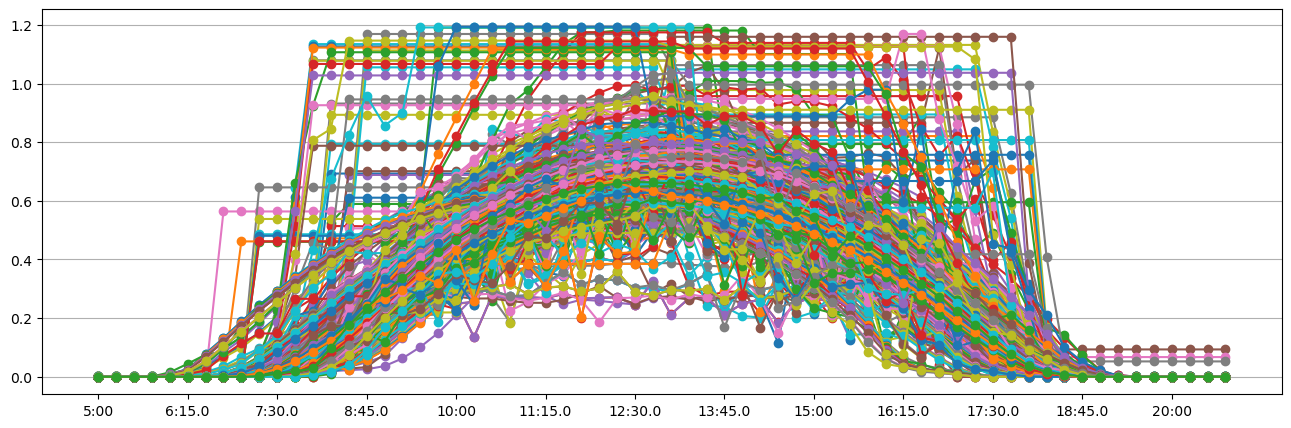

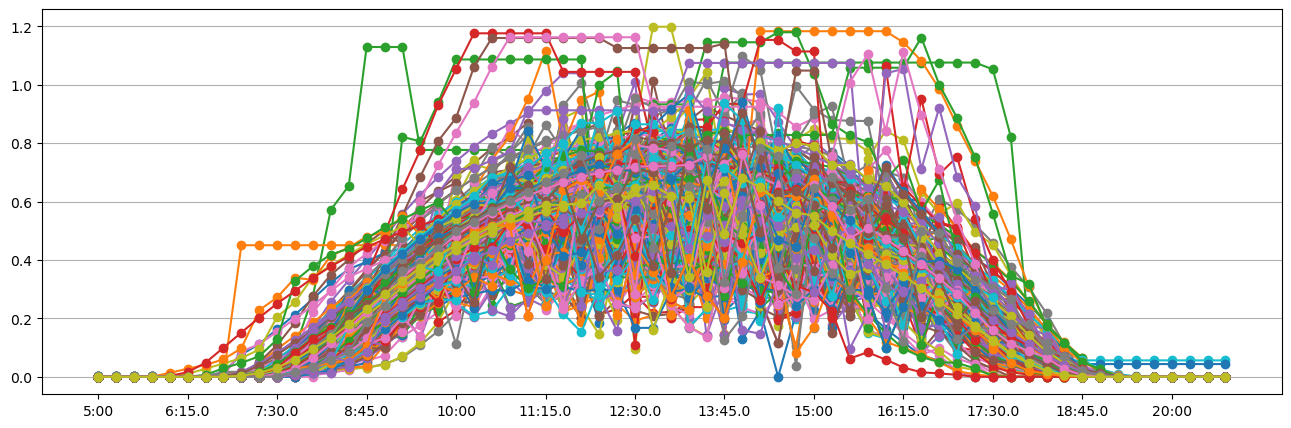

In [156]:
kmeans_results_plot(df=df_normalised_data, cluster_labels=cluster_labels_binary_dtw, cluster_num=2)

### 4.2. Kmeans with multiple clusters

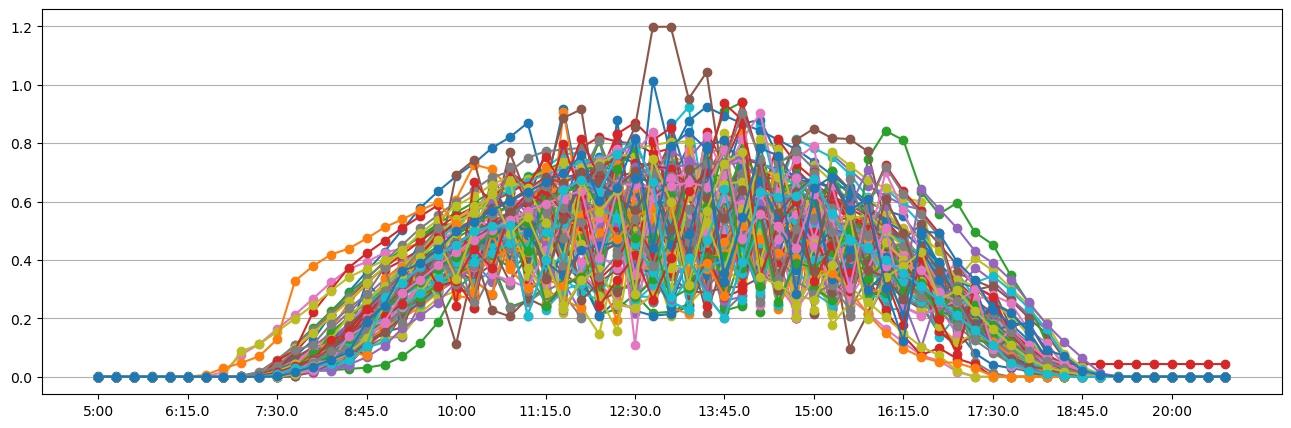

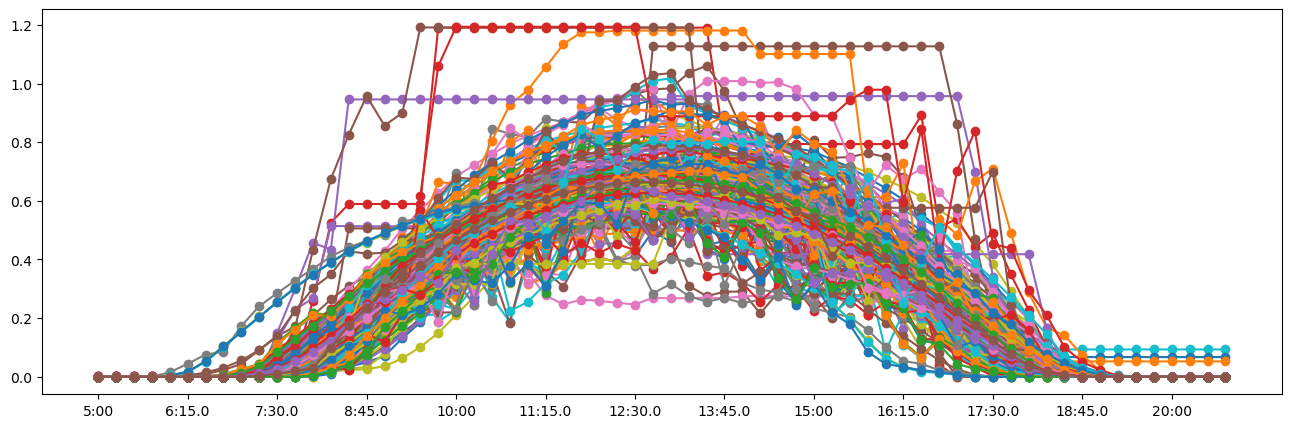

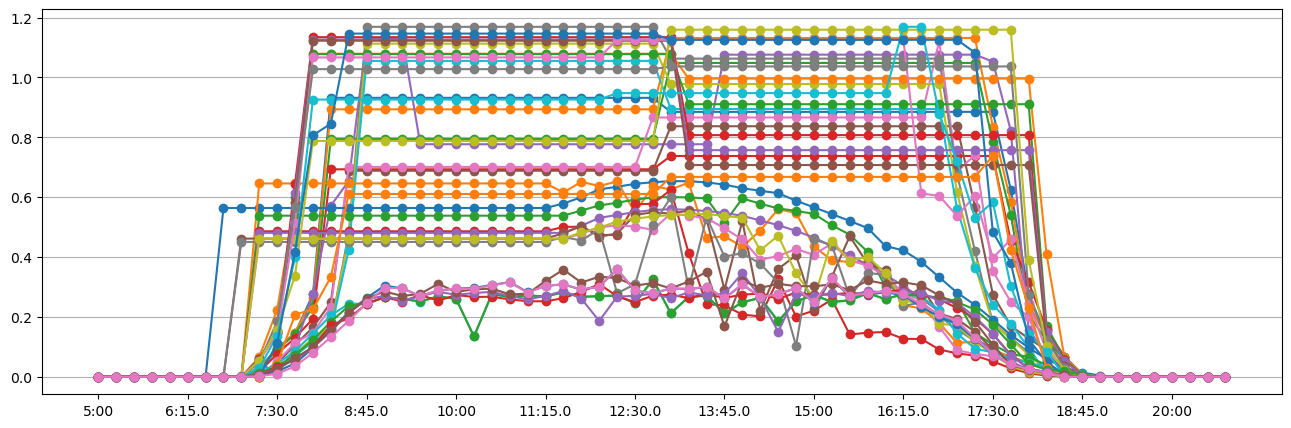

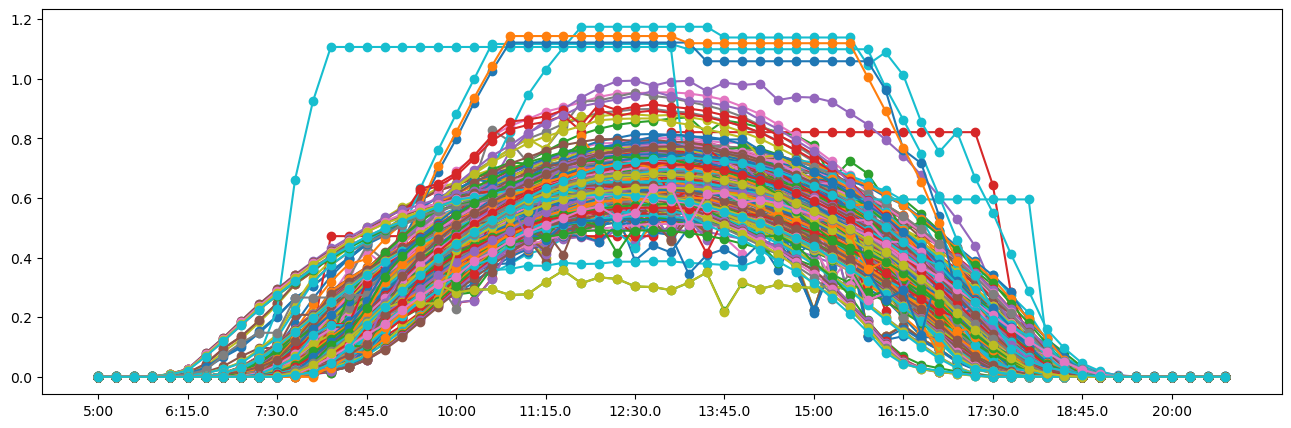

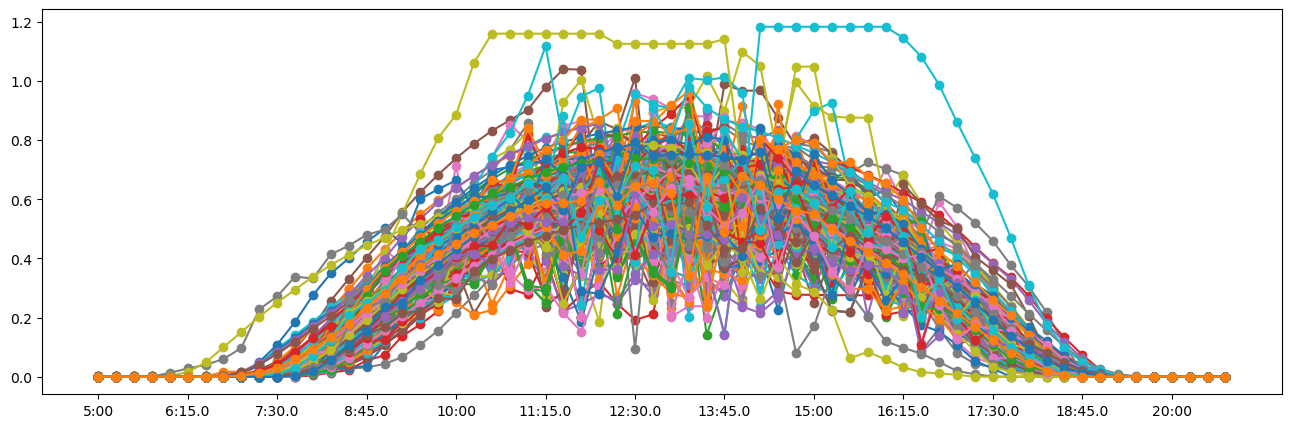

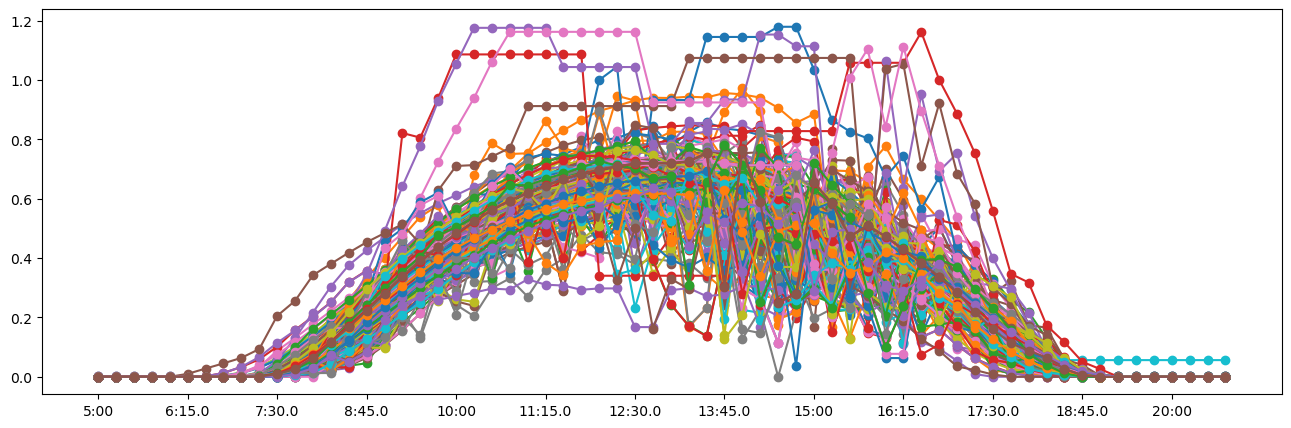

In [170]:
cluster_labels_multi_dtw = kmeans_clustering(df=df_normalised_data, cluster_num=6, metric_name='dtw')
kmeans_results_plot(df=df_normalised_data, cluster_labels=cluster_labels_multi_dtw, cluster_num=6)


## 4.2 Clustering with decomposition

### 4.2.1 Seasonal and Trend decomposition using Loess (STL)

In [158]:
from statsmodels.tsa.seasonal import STL

In [159]:
df_raw_decom = df_normalised.copy()
df_raw_decom['hour'] = df_raw_decom['time'].dt.hour
df_raw_decom = df_raw_decom[(df_raw_decom['hour']>=effective_start_time) & (df_raw_decom['hour']<=effective_end_time)]
df_raw_decom.set_index('time', inplace=True)
df_raw_decom.iloc[24:30, :]

MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
time                                                             
2023-04-01 11:00:00                                   0.469748   
2023-04-01 11:15:00                                   0.496759   
2023-04-01 11:30:00                                   0.512605   
2023-04-01 11:45:00                                   0.554682   
2023-04-01 12:00:00                                   0.584574   
2023-04-01 12:15:00                                   0.578691   

                     MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  MNTR|1367154  \
time                                                                           
2023-04-01 11:00:00                                   0.198740      0.259049   
2023-04-01 11:15:00                                   0.250702      0.185687   
2023-04-01 11:30:00                                   0.313396      0.228937   
2023-04-01 11:45:00                                   0.281527      0.129167   
2023-04-01 12:00:00                                   0.270400      0.087133   
2023-04-01 12:15:00                                   0.278610      0.113514   

                     MNTR|7KWG-VNRN-6XNR-G3P8  \
time                                            
2023-04-01 11:00:00                       0.0   
2023-04-01 11:15:00                       0.0   
2023-04-01 11:30:00                       0.0   
2023-04-01 11:45:00                       0.0   
2023-04-01 12:00:00                       0.0   
2023-04-01 12:15:00                       0.0   

                     MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78  \
time                                                             
2023-04-01 11:00:00                                   0.317667   
2023-04-01 11:15:00                                   0.336373   
2023-04-01 11:30:00                                   0.344984   
2023-04-01 11:45:00                                   0.235398   
2023-04-01 12:00:00                                   0.230880   
2023-04-01 12:15:00                                   0.166490   

                     MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842  \
time                                                             
2023-04-01 11:00:00                                   0.410335   
2023-04-01 11:15:00                                   0.536118   
2023-04-01 11:30:00                                   0.532949   
2023-04-01 11:45:00                                   0.551963   
2023-04-01 12:00:00                                   0.579186   
2023-04-01 12:15:00                                   0.588117   

                     MNTR|f1c33770-3ab6-4beb-9b6d-fb32dd408b15  \
time                                                             
2023-04-01 11:00:00                                   0.426702   
2023-04-01 11:15:00                                   0.338544   
2023-04-01 11:30:00                                   0.517419   
2023-04-01 11:45:00                                   0.556349   
2023-04-01 12:00:00                                   0.610652   
2023-04-01 12:15:00                                   0.576984   

                     MNTR|4e4995c9-16a4-40eb-b94c-ca937ecbb63f  \
time                                                             
2023-04-01 11:00:00                                   0.182643   
2023-04-01 11:15:00                                   0.214800   
2023-04-01 11:30:00                                   0.392402   
2023-04-01 11:45:00                                   0.519553   
2023-04-01 12:00:00                                   0.262622   
2023-04-01 12:15:00                                   0.303313   

                     MNTR|e7067180-db86-41b4-a5d0-243e89afd947  \
time                                                             
2023-04-01 11:00:00                                   0.194130   
2023-04-01 11:15:00                                   0.227836   
2023-04-01 11:30:00                                   0.167159   
2023-04-01 1

In [160]:
def stl_plot(df, trend, seasonal, residual):
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='best')
    plt.title('Original Time Series')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()


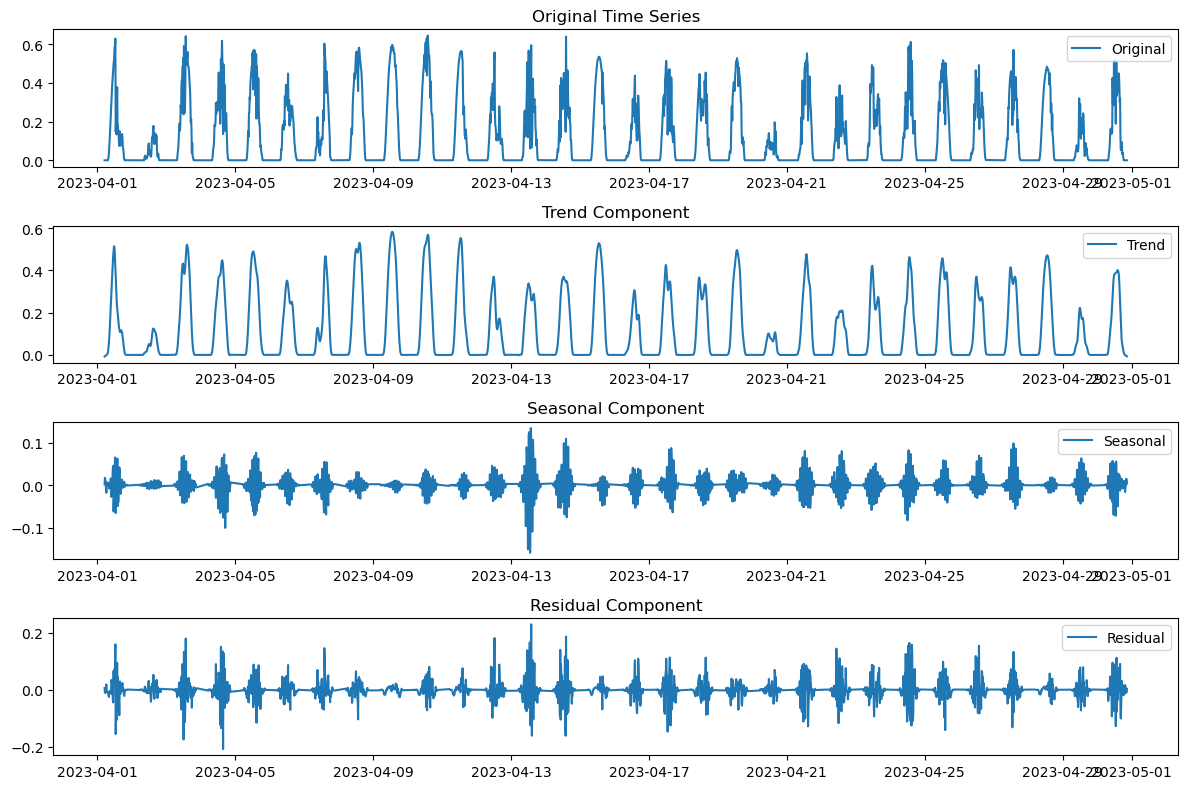

time  original:MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0    2023-04-01 05:00:00                                                0.0    
1    2023-04-01 05:15:00                                                0.0    
2    2023-04-01 05:30:00                                                0.0    
3    2023-04-01 05:45:00                                                0.0    
4    2023-04-01 06:00:00                                                0.0    
...                  ...                                                ...    
1915 2023-04-30 19:45:00                                                0.0    
1916 2023-04-30 20:00:00                                                0.0    
1917 2023-04-30 20:15:00                                                0.0    
1918 2023-04-30 20:30:00                                                0.0    
1919 2023-04-30 20:45:00                                                0.0    

      trend:MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0                                           -0.007536   
1                                           -0.005904   
2                                           -0.004456   
3                                           -0.003216   
4                                           -0.002109   
...                                               ...   
1915                                        -0.001731   
1916                                        -0.002781   
1917                                        -0.003929   
1918                                        -0.005274   
1919                                        -0.006805   

      seasonal:MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0                                              0.001481    
1                                              0.016874    
2                                              0.010678    
3                                              0.005588    
4                                             -0.008612    
...                                                 ...    
1915                                          -0.004932    
1916                                          -0.002669    
1917                                           0.014714    
1918                                           0.012545    
1919                                           0.003394    

      residual:MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0                                              0.006055    
1                                             -0.010971    
2                                             -0.006222    
3                                             -0.002372    
4                                              0.010722    
...                                                 ...    
1915                                           0.006663    
1916                                           0.005451    
1917                                          -0.010786    
1918                                          -0.007271    
1919                                           0.003411    

      original:MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  \
0                                                   0.0    
1                                                   0.0    
2                                                   0.0    
3                                                   0.0    
4                                                   0.0    
...                                                 ...    
1915                                                0.0    
1916                                                0.0    
1917                                                0.0    
1918                                                0.0    
1919                                                0.0    

      trend:MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  \
0                                       -7.117796e-04   
1                                       -5.752719e-04   
2                                       

In [161]:
# # =============================================
# = decomposition of each monitor at each day 
# # =============================================

df_stl = pd.DataFrame(index=np.arange(len(df_raw_decom)))
df_stl['time'] = df_raw_decom.index.values


for monitor_id in df_raw_decom.filter(regex=r'^MNTR').columns.to_list():
    stl = STL(df_raw_decom[monitor_id], period=6)
    result = stl.fit()
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
    df_stl['original:' + monitor_id] = df_raw_decom[monitor_id].values
    df_stl['trend:' + monitor_id] = trend.values
    df_stl['seasonal:' + monitor_id] = seasonal.values
    df_stl['residual:' + monitor_id] = residual.values
    
    if monitor_id == df_raw_decom.filter(regex=r'^MNTR').columns.to_list()[0]:
        stl_plot(df=df_raw_decom[monitor_id], trend=trend, seasonal=seasonal, residual=residual)
df_stl

In [162]:
# # =============================================
# = create data for clustering
# = 1. select clear-sky days
# = 2. combine different features
# # =============================================
efftime_list = df_effective_timeslots['hour_min'].values.tolist()
def create_data_forlearning(df, df_att, df_clearday, pvlist, date_list, fea_num, filter_name):
    if fea_num == 1:
        df_norm = pd.DataFrame(index=np.arange(len(date_list)*len(pvlist)), columns=['pvid_time'] + ['trend_' + str(element) for element in efftime_list])
        cols_multi_factor = 1
    else:
        if filter_name == 'stl':
            df_norm = pd.DataFrame(index=np.arange(len(date_list)*len(pvlist)), columns=['pvid_time'] + ['trend_' + str(element) for element in efftime_list] +
                                ['seasonal_' + str(element) for element in efftime_list] + ['residual_' + str(element) for element in efftime_list])
            cols_multi_factor = 3
        else:
            df_norm = pd.DataFrame(index=np.arange(len(date_list)*len(pvlist)), columns=['pvid_time'] + ['trend_' + str(element) for element in efftime_list] +
                                ['cycle_' + str(element) for element in efftime_list])
            cols_multi_factor = 2
    clearsky_index = 0
    for i, pvid in enumerate(pvlist):
        pvid_num = pvid.split('|')[1]
        site_id = df_att.loc[df_att['source']==pvid, 'siteId'].values[0]
        df_monitor = df.filter(regex=r'{}$'.format(pvid_num))
        df_monitor['date'] = df['time'].dt.date
        df_monitor['date'] = df_monitor['date'].astype(pd.StringDtype())

        for j, date_id in enumerate(date_list):
            index_id = i*len(date_list) + j
            pvid_time = pvid + ' ' + date_id
            df_monitor_date = df_monitor[df_monitor['date']==date_id]
            # df_monitor_date.drop(['original:{}'.format(pvid), 'date'], axis=1, inplace=True)
            if fea_num == 1:
                colums_value_list = df_monitor_date['trend:{}'.format(pvid)].values
            else:
                if filter_name == 'stl':
                    index_end = 4
                else:
                    index_end = 3
                colums_value_list = pd.concat([df_monitor_date[col] for col in df_monitor_date.columns.to_list()[1:index_end]], ignore_index=True).values

            if if_only_clearsky is True:
                if site_id in df_clearday.columns.to_list()[1:]:
                    clearday_pvsite = df_clearday.loc[df_clearday['date']==date_id, site_id].values[0]
                    # print(pvid, date_id, clearday_pvsite)
                    if clearday_pvsite == True:
                        df_monitor_date['effective'] = df_monitor_date['original:{}'.format(pvid)] >threshold_for_effective_power
                        if df_monitor_date['effective'].sum()/len(df_monitor_date)>threshold_for_effective_time:
                            if len(colums_value_list) == effective_timeslots_daily*cols_multi_factor:
                                df_norm.iloc[clearsky_index, 0] = pvid_time
                                df_norm.iloc[clearsky_index, 1:] = np.array(colums_value_list)
                            clearsky_index += 1    
            else:
                if len(colums_value_list) == effective_timeslots_daily:
                    df_norm.iloc[index_id, 0] = pvid_time
                    df_norm.iloc[index_id, 1:] = np.array(colums_value_list)

    df_norm.dropna(how='all', inplace=True)
    return df_norm

In [164]:
df_normalised_stl = create_data_forlearning(df=df_stl, df_att=df_att, df_clearday=df_clearday_all, pvlist=pvlist, date_list=date_list, fea_num=3, filter_name='stl')
df_normalised_stl

pvid_time trend_5:00  \
0     MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb 2023...  -0.000159   
1     MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb 2023...   0.000101   
2     MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...  -0.000398   
3     MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...   0.000491   
4     MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...  -0.000126   
...                                                 ...        ...   
1487                      MNTR|1148485_1_1_1 2023-04-23   -0.00017   
1488                            MNTR|6039646 2023-04-02   0.000357   
1489                            MNTR|6039646 2023-04-03  -0.000033   
1490                            MNTR|6039646 2023-04-04    0.00003   
1491                      MNTR|1189660_1_2_1 2023-04-09  -0.000032   

     trend_5:15.0 trend_5:30.0 trend_5:45.0 trend_6:00 trend_6:15.0  \
0       -0.000309    -0.000169      0.00004   0.000168     0.000182   
1        0.000097     0.000211     0.000362   0.000472     0.000511   
2       -0.000216     0.000177     0.000497    0.00058     0.000378   
3        0.000243    -0.000094    -0.000219  -0.000127     0.000032   
4        0.000536     0.000978     0.001106      0.001     0.000847   
...           ...          ...          ...        ...          ...   
1487    -0.000299    -0.000379     -0.00036   -0.00012     0.000311   
1488     0.000601     0.000491     0.000289   0.000491     0.001544   
1489     -0.00008     0.000119      0.00046   0.000769      0.00141   
1490    -0.000017    -0.000058    -0.000025   0.000189     0.001242   
1491    -0.000181     0.000159     0.000611   0.000658     0.000499   

     trend_6:30.0 trend_6:45.0 trend_7:00  ... residual_18:30.0  \
0        0.000245     0.000945   0.003121  ...        -0.026009   
1        0.000653     0.001385   0.003469  ...        -0.020156   
2        0.000318     0.001486   0.005258  ...        -0.025681   
3        0.000351     0.001281   0.003488  ...         -0.02644   
4        0.000846     0.001386   0.003132  ...         0.004589   
...           ...          ...        ...  ...              ...   
1487     0.000667     0.000805   0.000917  ...        -0.022245   
1488      0.00414     0.009356    0.01842  ...        -0.017464   
1489     0.003512     0.008543   0.018071  ...        -0.016258   
1490     0.003711     0.008284   0.016133  ...        -0.016701   
1491     0.000891     0.002521   0.006323  ...        -0.018463   

     residual_18:45.0 residual_19:00 residual_19:15.0 residual_19:30.0  \
0           -0.020404      -0.013318        -0.008757        -0.001356   
1           -0.013852       -0.01997        -0.005535         0.010471   
2           -0.021321      -0.017492        -0.009128        -0.002319   
3           -0.021572      -0.015541        -0.006867        -0.003826   
4            -0.02384      -0.013609        -0.000702         0.002972   
...               ...            ...              ...              ...   
1487        -0.015536      -0.007544        -0.002525         0.000165   
1488          -0.0134      -0.007585        -0.003146        -0.000623   
1489        -0.012964      -0.005703         0.000104        -0.000445   
1490        -0.011927      -0.005859        -0.002349         0.000315   
1491        -0.014459      -0.007183        -0.002056         0.001383   

     residual_19:45.0 residual_20:00 residual_20:15.0 residual_20:30.0  \
0             0.00394       0.001503        -0.000027        -0.000911   
1             0.00444      -0.000604        -0.004067        -0.003324   
2            0.003653       0.001124        -0.001202        -0.000977   
3            0.004361       0.000129        -0.001382          -0.0003   
4           -0.000211      -0.002649        -0.000377        -0.000742   
...               ...            ...              ...              ...   
1487         0.001941       0.000414         -0.00119        -0.001752   
1488         0.001127       0.000827         0.000407        -0.00

### 4.2.2 Multiple Kmeans with STL

In [168]:
stl_cluster_labels_multi = kmeans_clustering(df=df_normalised_stl, cluster_num=6, metric_name='dtw')


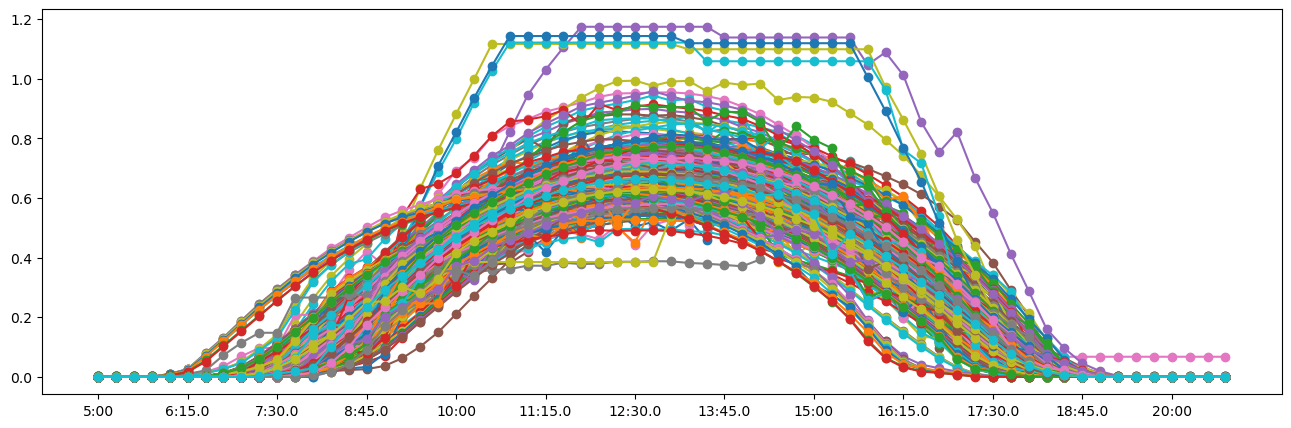

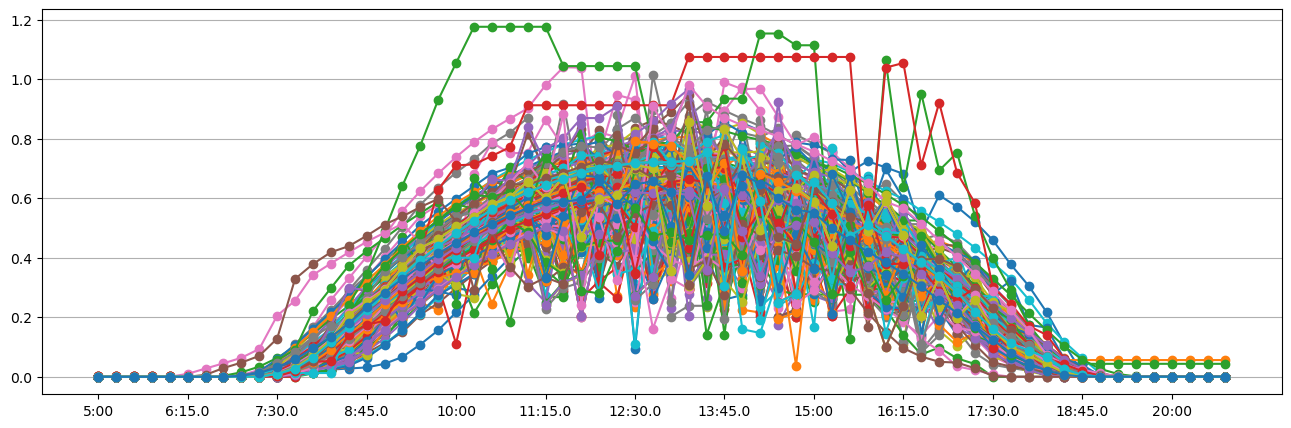

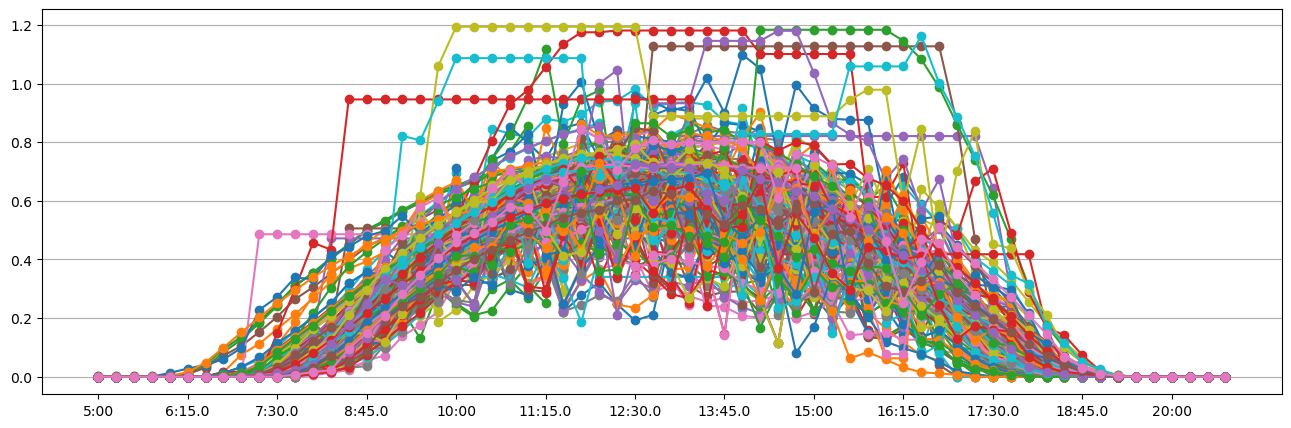

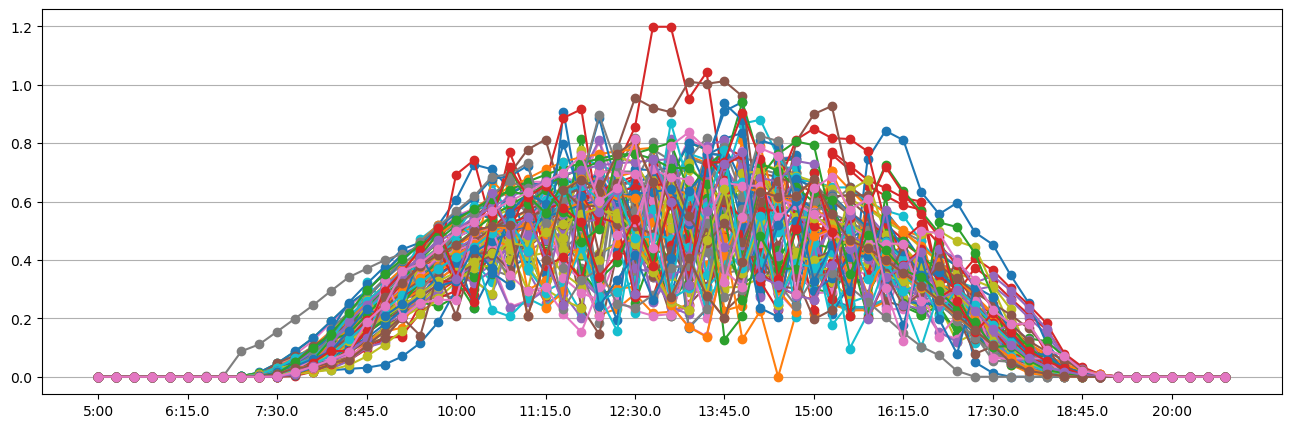

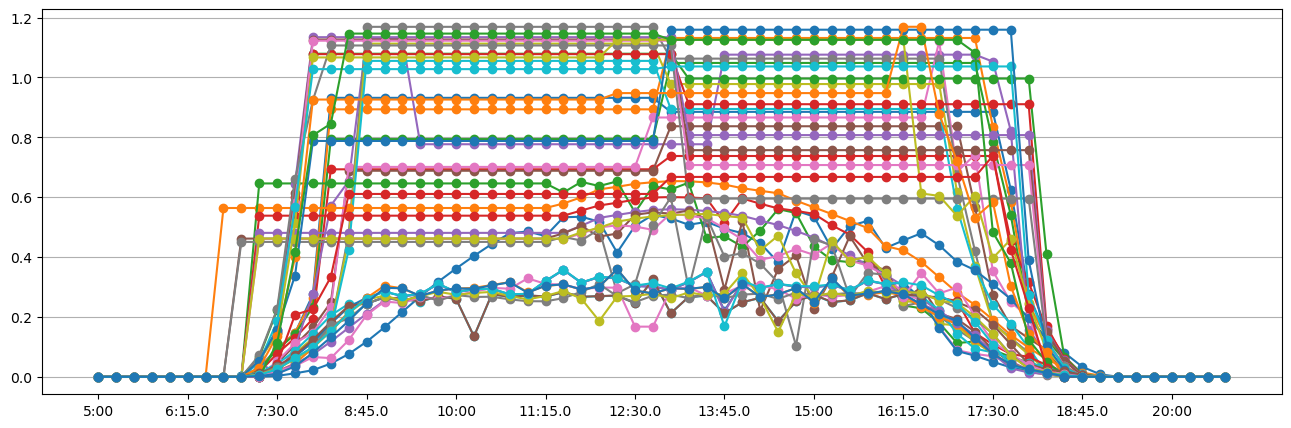

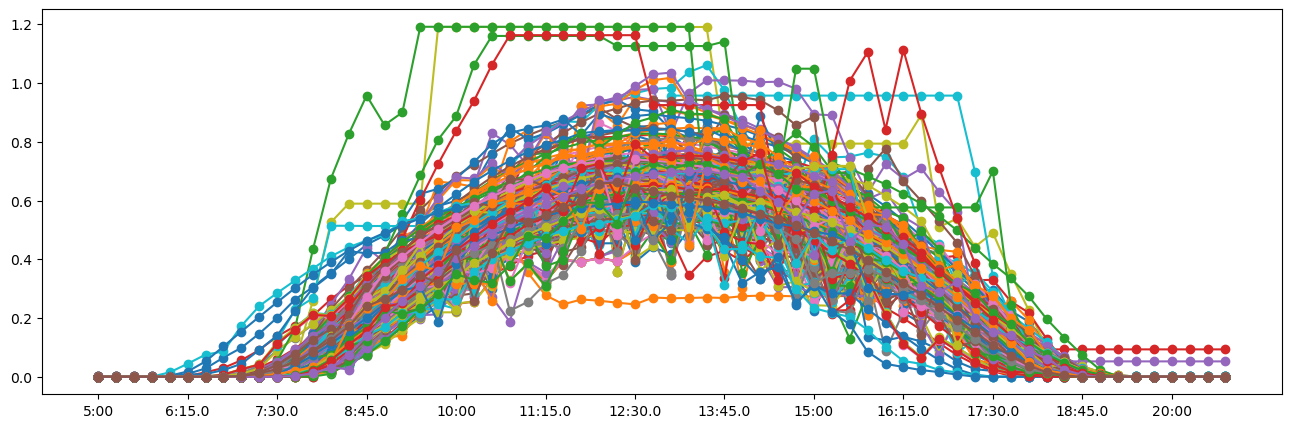

In [169]:
kmeans_results_plot(df=df_normalised_data, cluster_labels=stl_cluster_labels_multi, cluster_num=6)

### 4.2.3 The Hodrick-Prescott (HP) filter (HPFilter)

In [178]:
def hpfilter_plot(df, trend, cyclical):
    plt.figure(figsize=(20, 6))

    plt.subplot(311)
    plt.plot(df, label='Original')
    plt.legend(loc='best')
    plt.title('Original Time Series')

    plt.subplot(312)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.title('Trend Component')

    plt.subplot(313)
    plt.plot(cyclical, label='Cyclical')
    plt.legend(loc='best')
    plt.title('Cyclical Component')

    plt.tight_layout()
    plt.show()

In [172]:
import statsmodels.api as sm

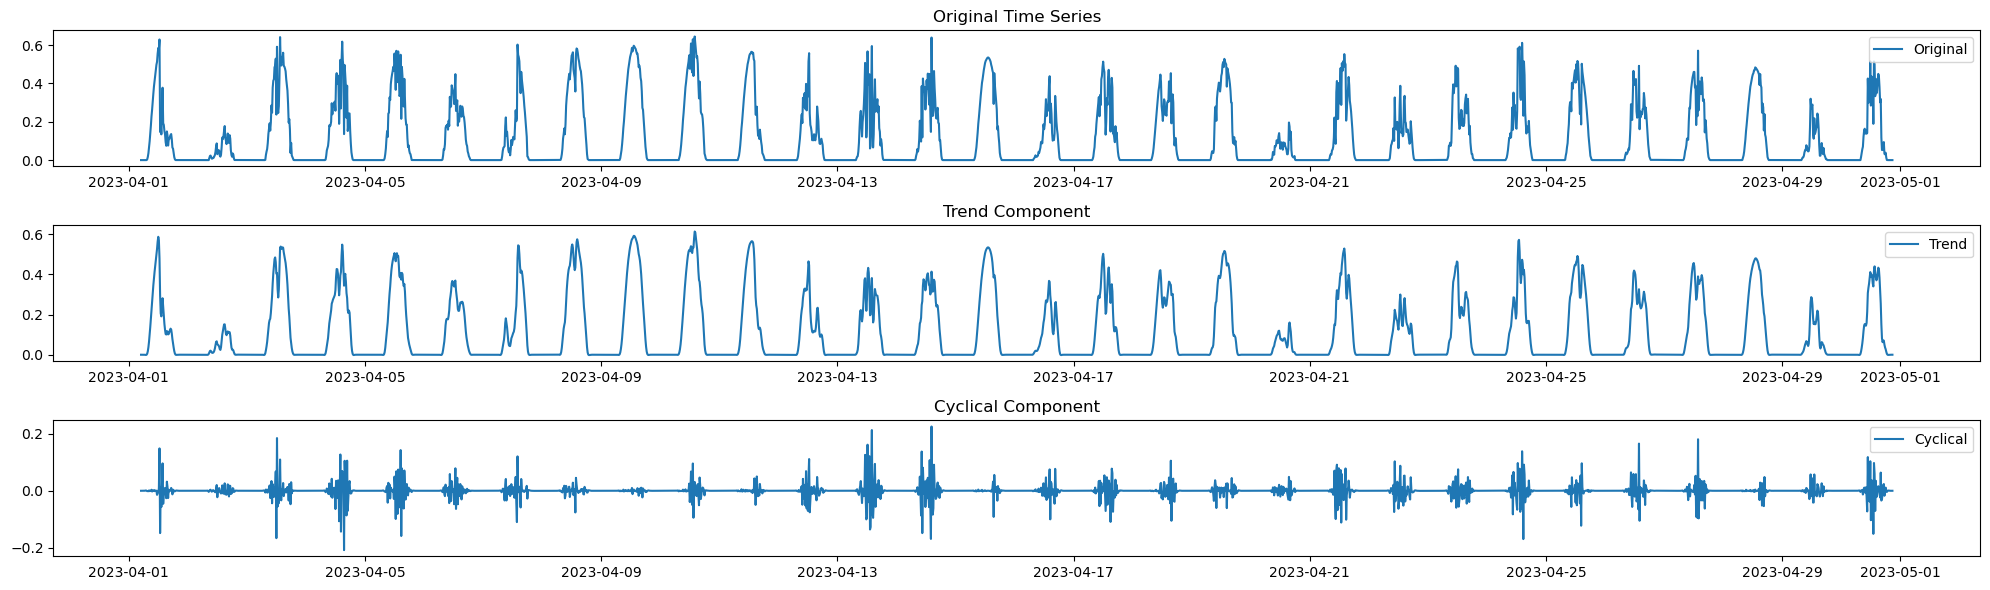

time  original:MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0    2023-04-01 05:00:00                                                0.0    
1    2023-04-01 05:15:00                                                0.0    
2    2023-04-01 05:30:00                                                0.0    
3    2023-04-01 05:45:00                                                0.0    
4    2023-04-01 06:00:00                                                0.0    
...                  ...                                                ...    
1915 2023-04-30 19:45:00                                                0.0    
1916 2023-04-30 20:00:00                                                0.0    
1917 2023-04-30 20:15:00                                                0.0    
1918 2023-04-30 20:30:00                                                0.0    
1919 2023-04-30 20:45:00                                                0.0    

      trend:MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0                                           -0.000003   
1                                            0.000002   
2                                            0.000012   
3                                            0.000027   
4                                            0.000032   
...                                               ...   
1915                                        -0.000026   
1916                                         0.000026   
1917                                         0.000023   
1918                                         0.000010   
1919                                        -0.000001   

      cyclical:MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb  \
0                                              0.000003    
1                                             -0.000002    
2                                             -0.000012    
3                                             -0.000027    
4                                             -0.000032    
...                                                 ...    
1915                                           0.000026    
1916                                          -0.000026    
1917                                          -0.000023    
1918                                          -0.000010    
1919                                           0.000001    

      original:MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  \
0                                                   0.0    
1                                                   0.0    
2                                                   0.0    
3                                                   0.0    
4                                                   0.0    
...                                                 ...    
1915                                                0.0    
1916                                                0.0    
1917                                                0.0    
1918                                                0.0    
1919                                                0.0    

      trend:MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  \
0                                       -1.399047e-06   
1                                       -3.278658e-07   
2                                        2.741953e-06   
3                                        1.027743e-05   
4                                        2.082850e-05   
...                                               ...   
1915                                    8.626910e-117   
1916                                    3.738074e-117   
1917                                    7.830461e-118   
1918                                   -2.615806e-118   
1919                                   -5.378501e-118   

      cyclical:MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad  \
0                                          1.399047e-06    
1                                          3.278658e-07    
2                                         -2.741953e-06    
3      

In [179]:
# # ================================================================
# = decomposition of each monitor at each day with HPFilter
# # ================================================================

df_hpf = pd.DataFrame(index=np.arange(len(df_raw_decom)))
df_hpf['time'] = df_raw_decom.index.values

for monitor_id in df_raw_decom.filter(regex=r'^MNTR').columns.to_list():
    cycle, trend = sm.tsa.filters.hpfilter(df_raw_decom[monitor_id], lamb=0.7)
    df_hpf['original:' + monitor_id] = df_raw_decom[monitor_id].values
    df_hpf['trend:' + monitor_id] = trend.values
    df_hpf['cyclical:' + monitor_id] = cycle.values
    
    if monitor_id == df_raw_decom.filter(regex=r'^MNTR').columns.to_list()[0]:
        hpfilter_plot(df=df_raw_decom[monitor_id], trend=trend, cyclical=cycle)
df_hpf

In [175]:
df_normalised_hpf = create_data_forlearning(df=df_hpf, df_att=df_att, df_clearday=df_clearday_all, pvlist=pvlist, date_list=date_list, fea_num=3, filter_name='hpf')
df_normalised_hpf

pvid_time trend_5:00  \
0     MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb 2023...  -0.000002   
1     MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb 2023...   0.000257   
2     MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...   0.000004   
3     MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...   0.000115   
4     MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad 2023...   0.000437   
...                                                 ...        ...   
1487                      MNTR|1148485_1_1_1 2023-04-23  -0.000001   
1488                            MNTR|6039646 2023-04-02    0.00001   
1489                            MNTR|6039646 2023-04-03    0.00012   
1490                            MNTR|6039646 2023-04-04   0.000007   
1491                      MNTR|1189660_1_2_1 2023-04-09       -0.0   

     trend_5:15.0 trend_5:30.0 trend_5:45.0 trend_6:00 trend_6:15.0  \
0       -0.000001     0.000005      0.00002   0.000035     0.000016   
1        0.000342     0.000375     0.000389   0.000397     0.000373   
2        0.000002      0.00001     0.000032   0.000057     0.000026   
3        0.000019    -0.000004     0.000008   0.000024     0.000003   
4        0.000583     0.000632     0.000644   0.000648      0.00063   
...           ...          ...          ...        ...          ...   
1487    -0.000002    -0.000002     0.000001   0.000011     0.000031   
1488     0.000022     0.000028    -0.000017  -0.000197    -0.000574   
1489     0.000039     0.000019    -0.000017  -0.000176    -0.000539   
1490     0.000018     0.000025    -0.000008  -0.000158    -0.000485   
1491     0.000003      0.00001     0.000019   0.000007    -0.000069   

     trend_6:30.0 trend_6:45.0 trend_7:00  ... cycle_18:30.0 cycle_18:45.0  \
0       -0.000121    -0.000486  -0.001013  ...     -0.003367      0.000158   
1        0.000236    -0.000114  -0.000598  ...      0.000923      0.001542   
2       -0.000201      -0.0008  -0.001659  ...      0.000973      0.002392   
3       -0.000132    -0.000461  -0.000873  ...      0.001158      0.001746   
4        0.000522     0.000231  -0.000206  ...      0.004961     -0.002673   
...           ...          ...        ...  ...           ...           ...   
1487     0.000049     0.000009  -0.000214  ...     -0.000408      0.000359   
1488    -0.000925    -0.000213   0.003926  ...     -0.000514     -0.000336   
1489    -0.000937    -0.000428   0.003266  ...     -0.000424     -0.000753   
1490    -0.000827    -0.000325   0.003056  ...     -0.000512      0.000064   
1491    -0.000267    -0.000545  -0.000481  ...      0.001606      0.000208   

     cycle_19:00 cycle_19:15.0 cycle_19:30.0 cycle_19:45.0 cycle_20:00  \
0       0.000748      0.001198      0.000649      0.000197    0.000008   
1       0.000582      0.000643      0.000312      0.000081   -0.000005   
2      -0.000779      0.000837      0.000842      0.000393    0.000094   
3      -0.000731      0.001041      0.000836      0.000339    0.000042   
4       0.000437      0.000825      0.000457      0.000124   -0.000037   
...          ...           ...           ...           ...         ...   
1487    0.001487      0.000918      0.000314      0.000026   -0.000046   
1488    0.001176       0.00085       0.00033      0.000046   -0.000042   
1489    0.000751      0.000725      0.000333      0.000077   -0.000015   
1490    0.001076      0.000704      0.000253      0.000028   -0.000032   
1491    0.000785      0.000632      0.000264      0.000049    -0.00002   

     cycle_20:15.0 cycle_20:30.0 cycle_20:45.0  
0         -0.00003     -0.000043     -0.000111  
1        -0.000018     -0.000021     -0.000055  
2        -0.000016     -0.000029     -0.000016  
3        -0.000049      0.000012      0.000243  
4        -0.000065      0.000053      0.000425  
...            ...           ...           ...  
1487     -0.000035     -0.000015     -0.000002  
1488     -0.000041      0.000005      0.000108  
1489     -0.000025     -0.000013     -0.000005  
1490     -0.000026      -0.00001    

### 4.2.4. Multiple Kmeans with HPFilter

In [176]:
hpf_cluster_labels_multi = kmeans_clustering(df=df_normalised_hpf, cluster_num=10, metric_name='dtw')

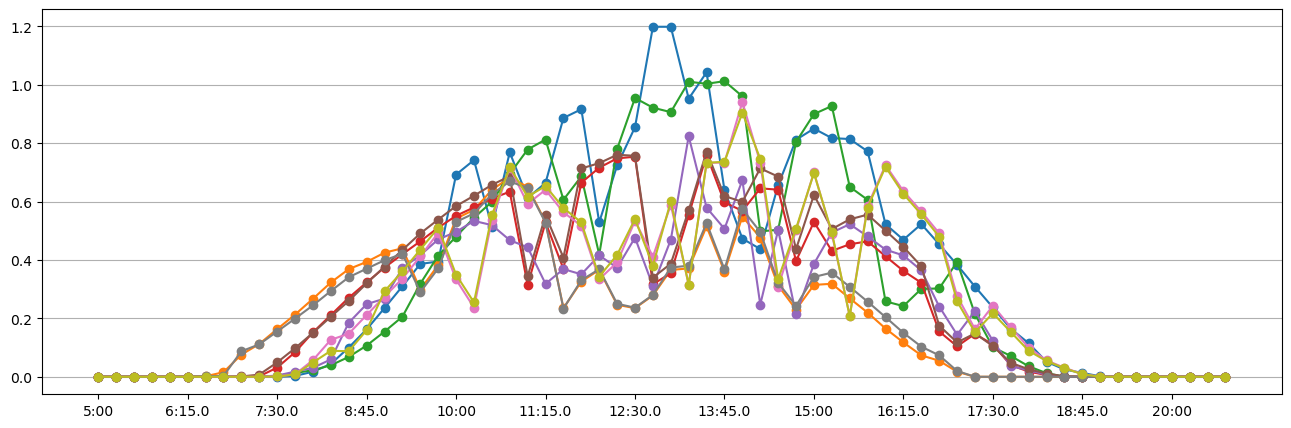

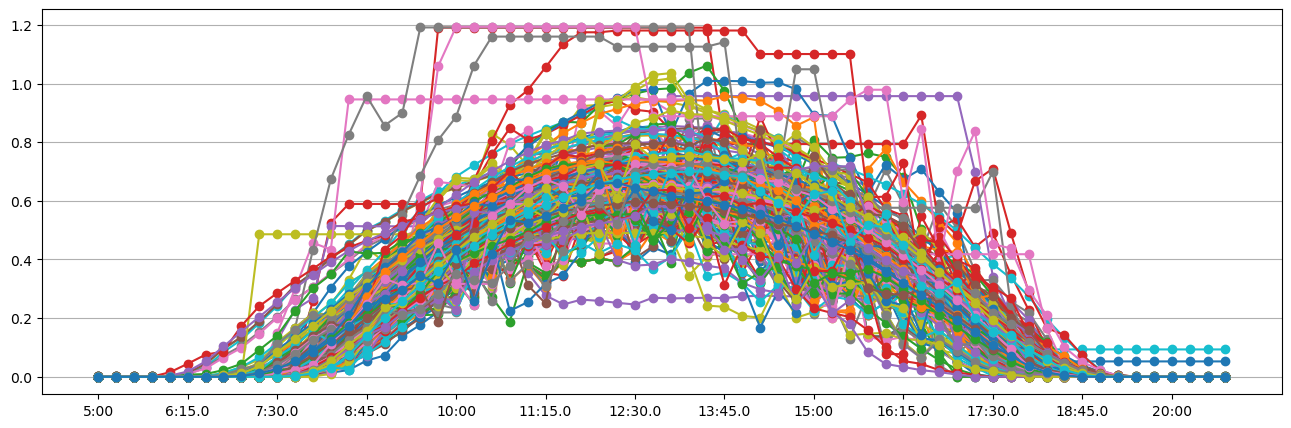

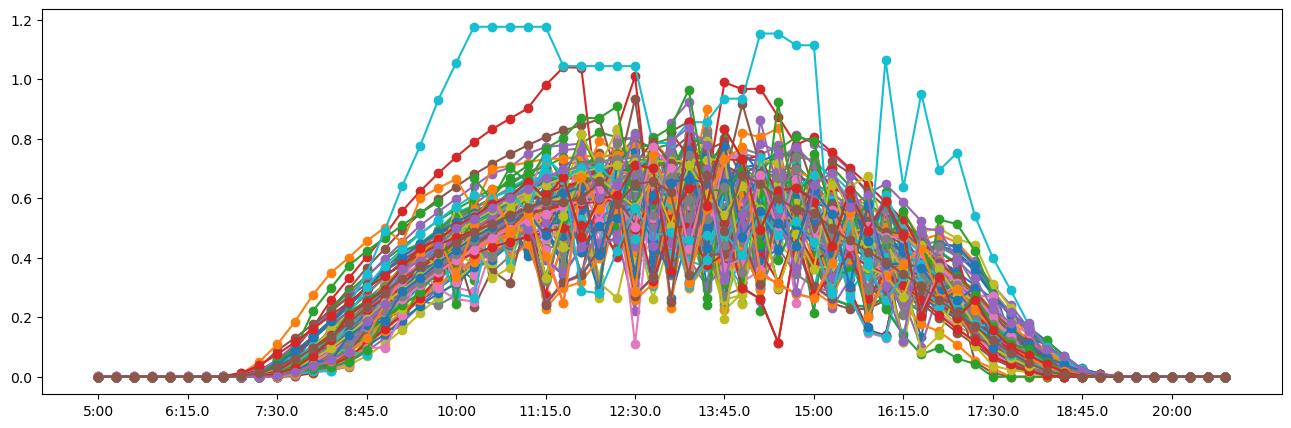

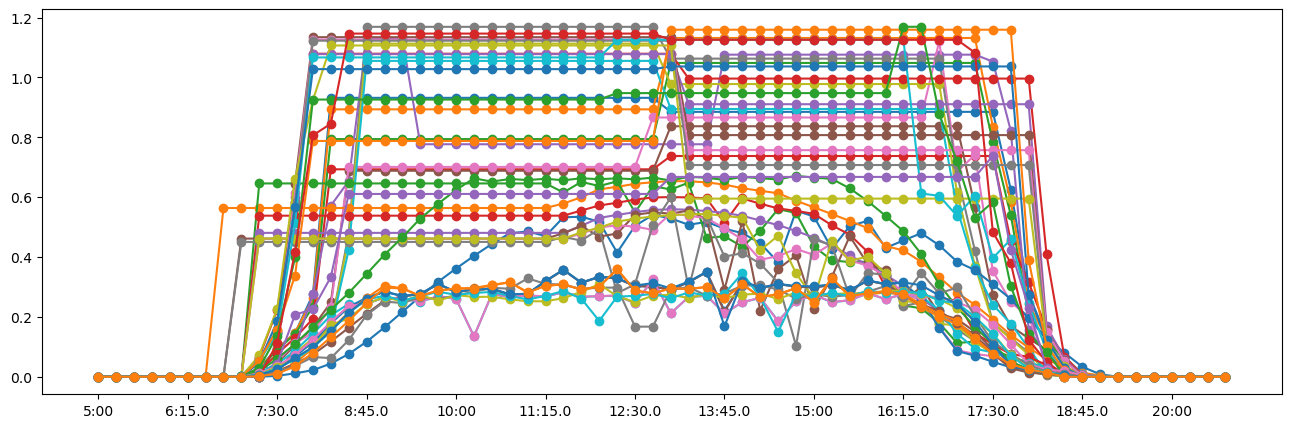

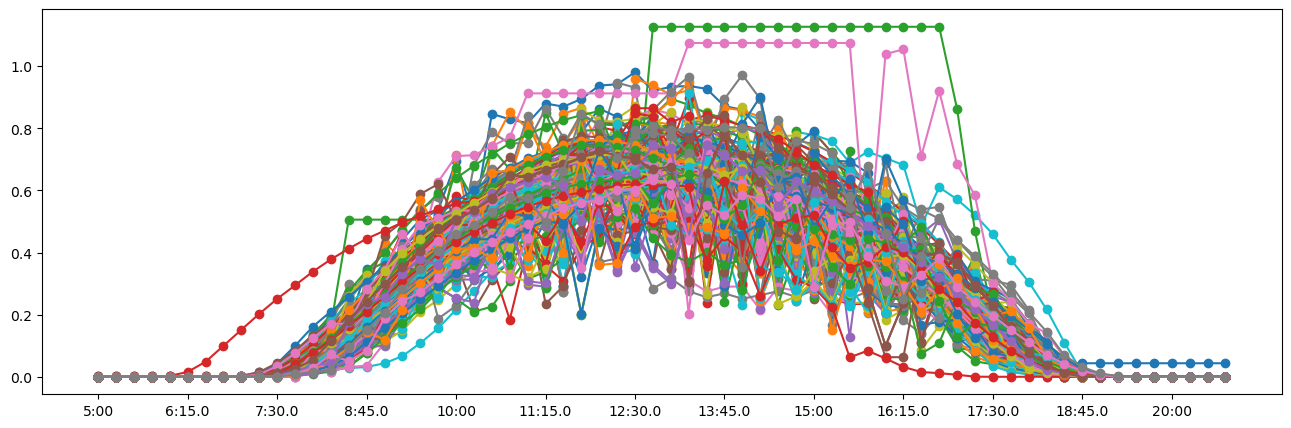

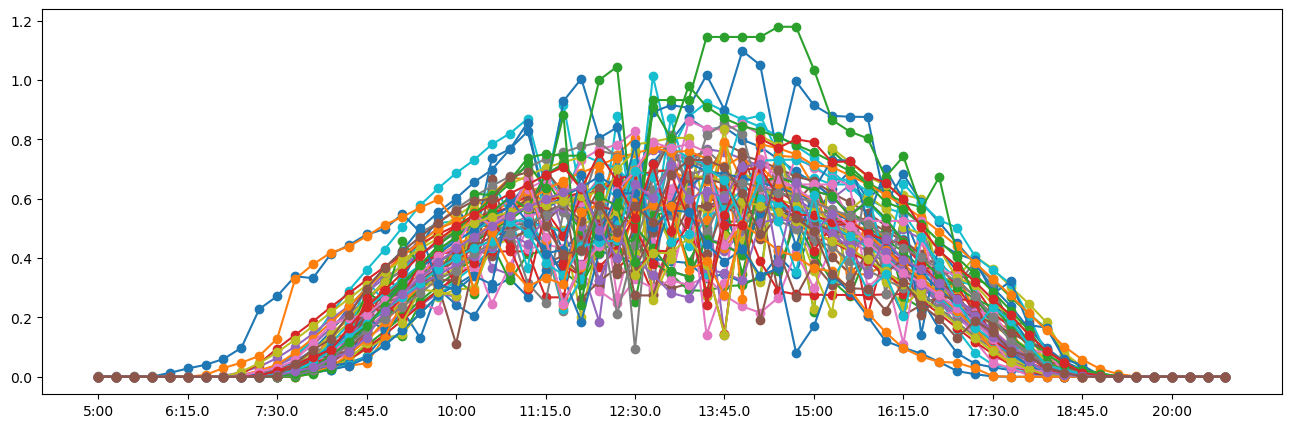

In [177]:
kmeans_results_plot(df=df_normalised_data, cluster_labels=hpf_cluster_labels_multi, cluster_num=6)